## Settings

In [1]:
!pip install pyfim

import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
from fim import apriori

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/BDA/')

%cd '/content/drive/MyDrive/BDA/'

/content


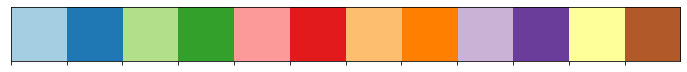

In [4]:
# setup colab
# Set palette for plots.
colors = ["#85BB65", "#ED3E2F"]  # Green and red for edible and poisonous.
palette = sns.color_palette('Paired')
sns.palplot(palette)

## Dataset description

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely ``edible``, definitely ``poisonous``, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

### Motivations

According to a study done by NPDS (National Poison Data System), the ingestion of wild and potential toxic mushrooms is common. In particular, citing the abstract 'Mushroom poisoning epidemiology in the United States' (1999-2016):
- Over the last 18 years, 133,700 cases (7428/year) of mushroom exposure, mostly by ingestion, have been reported. Cases are most frequently unintentional (83%, P < 0.001)
- Misidentification of edible mushrooms species appear to be the most common cause, and it may be prevented through education.
     
For this reason we focused our research in analyzing two families of mushrooms from America, wondering if it was possible to generalize some simple rules in detecting the poisonousness using this dataset, and if it was possible to identify which are the most relevant features.

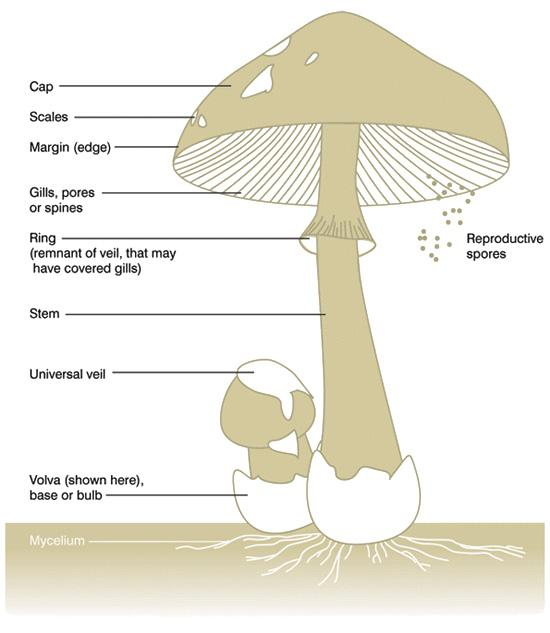

### Attributes Information: (classes: edible=e, poisonous=p)

 The attributes and the possible categories of each attribute are listed below:


- The ``cap-shape``:  bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s.
- The ``cap-surface``: fibrous=f, grooves=g, scaly=y, smooth=s
- The ``cap-color``: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e,  white=w, yellow=y
- The ``bruises``: bruises=t, no=f
- The ``odor``: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
- The ``gill-attachment``: attached=a, descending=d, free=f, notched=n
- The ``gill-spacing``: close=c, crowded=w, distant=d
- The ``gill-size``: broad=b, narrow=n
- The ``gill-color``: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
- The ``stalk-shape``: enlarging=e, tapering=t
- The ``stalk-root``: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
- The ``stalk-surface-above-ring``: fibrous=f, scaly=y, silky=k, smooth=s
- The ``stalk-surface-below-ring``: fibrous=f, scaly=y, silky=k, smooth=s
- The ``stalk-color-above-ring``: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
- The ``stalk-color-below-ring``: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
- The ``veil-type``: partial=p, universal=u
- The ``veil-color``: brown=n, orange=o, white=w, yellow=y
- The ``ring-number``: none=n, one=o, two=t
- The ``ring-type``: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
- The ``spore-print-color``: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
- The ``population``: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
- The ``habitat``: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d



The dataset consists of 8124 observations with 23 columns: 22 attributes and the edibility class.

In [5]:
df = pd.read_csv('mushrooms.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Since every attribute consists of a single character with unique meaning, we decided to convert object types into category types.

In [6]:
df = df.astype('category')

## Data Cleaning

First, we started analyzing the values of the attributes looking for missing values, errors or other interesting properties. Among all the attributes, we found:

In [7]:
col_to_analyze= ['ring-number','stalk-root','veil-type']
for col in col_to_analyze:
    values= df[col].unique().astype(str)
    print(col, ': ', values) 

ring-number :  ['o' 't' 'n']
stalk-root :  ['e' 'c' 'b' 'r' '?']
veil-type :  ['p']


Since we noticed that ring-number is an ordinal attribute, we mapped this feature in the following way:
* n (none) -> 0
* o (one) -> 1
* t (two) -> 2

In [8]:
# Setting the number of rings as numerical values.

df['ring-number'] = df['ring-number'].map({'n':0, 'o':1, 't':2}).astype(str)

In [9]:
# We can remove the attribute 'veil-type' because it has only the value 'p'.

df.drop(columns=['veil-type'], inplace=True)

### Stalk root analysis '?'

Since ***stalk-root*** has a high number of unknown values (30%), we have few options:
-  delete column
-  fill the unknown values in some way:
    - Perfom some clustering such as KMode to identify clusters and assign to the record woth unknown value the mode of the centroids. 



In [10]:
perc = len(df[df['stalk-root'] == '?']) / len(df) * 100
print(f'the percentage of missing values in stalk-root is: {round(perc, 2)}%')

the percentage of missing values in stalk-root is: 30.53%


In [11]:
!pip install kmodes
from kmodes.kmodes import KModes

2
Best run was number 1
3
Best run was number 1
4
Best run was number 1
5
Best run was number 3
6
Best run was number 3
7
Best run was number 1
8
Best run was number 2
9
Best run was number 2


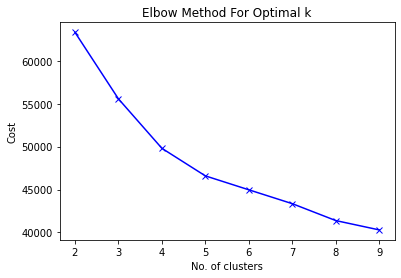

In [12]:
cost = list()
K = range(2, 10)
for num_clusters in list(K):
    print(num_clusters)
    kmode = KModes(n_clusters=num_clusters, init = 'random', n_init = 3, verbose=1, n_jobs= -1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [13]:
df['stalk-root'].unique()

['e', 'c', 'b', 'r', '?']
Categories (5, object): ['e', 'c', 'b', 'r', '?']

In [14]:
n_clusters = 4
kmode = KModes(n_clusters=n_clusters, init = 'random', n_init = 15 )
cols= ['odor','gill-spacing', 'gill-size', 'bruises']
labels= kmode.fit_predict(df[cols])

In [15]:
df['centroid']= labels

In [16]:
for i in range(n_clusters):
    print(f'-- {i}')
    print(df[df['centroid'] == i]['stalk-root'].value_counts())

-- 0
b    2240
c     512
?     384
e     256
r     192
Name: stalk-root, dtype: int64
-- 1
e    768
?    288
b    144
c      8
r      0
Name: stalk-root, dtype: int64
-- 2
?    1808
e      96
b      96
r       0
c       0
Name: stalk-root, dtype: int64
-- 3
b    1296
c      36
r       0
e       0
?       0
Name: stalk-root, dtype: int64


In [17]:
df.drop(columns= 'centroid', inplace= True)

Since the results are not so clear and the unknown values are a consistent number, for the moment we decided to ignore 'stalk-root'.

## Data exploration

Now we start with the visual exploration of our data.

### Attributes distribution

Here the simple summary plot of all the distributions of attributes among their values.

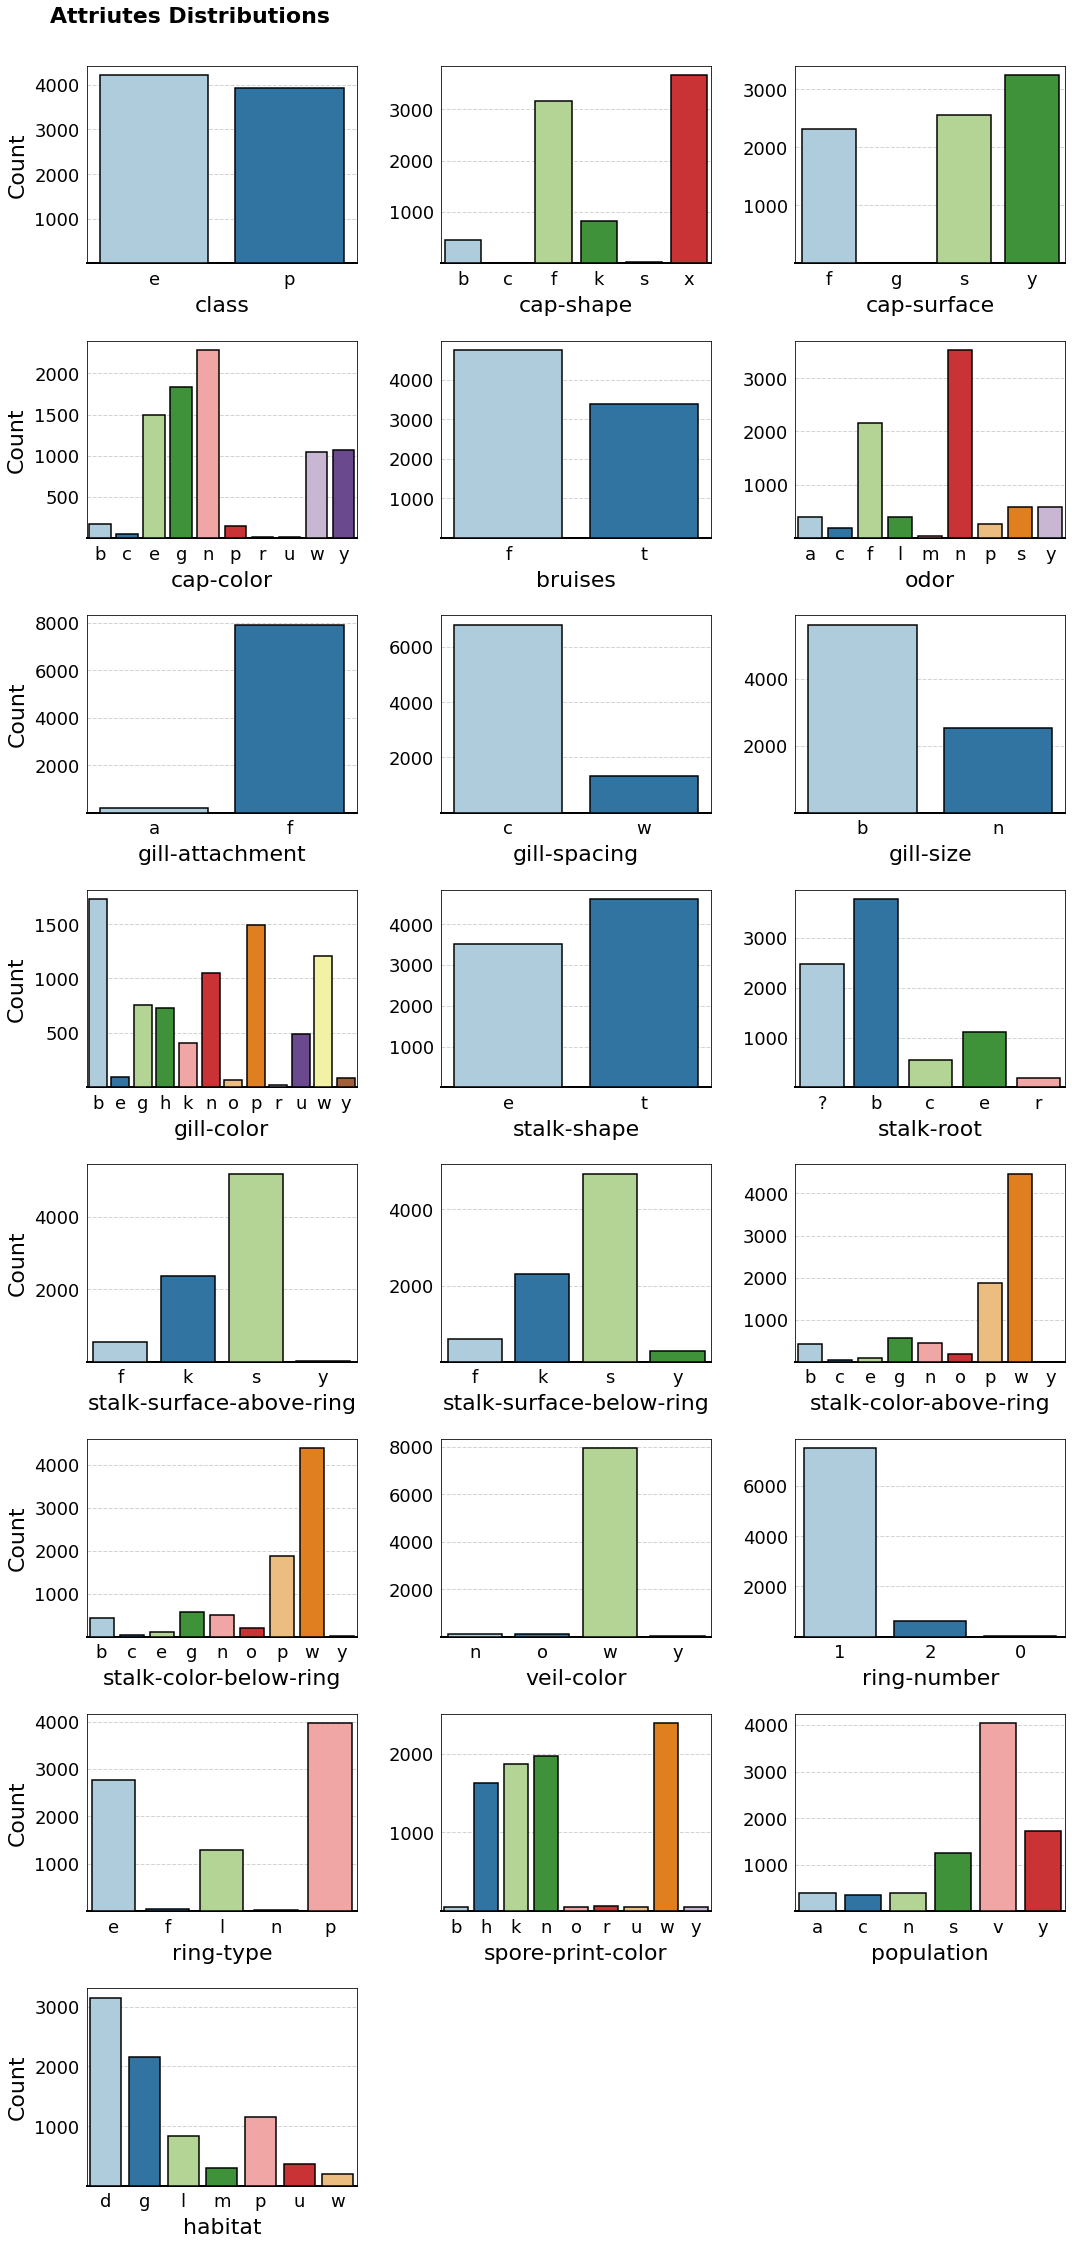

In [18]:
# Exploration of the attributes distribution.
rows = 12
cols = 3
fig = plt.figure(figsize=(15, 45))
fig.set_facecolor("#fff")
for idx, feature in enumerate(df.columns[:].tolist()):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.set_facecolor("#fff")
    ax.grid(axis="y", linewidth=1, color="lightgrey", linestyle="--", zorder=1)
    sns.countplot(x=feature, palette=palette, data=df, ec="#000", alpha=1, linewidth=1.5, zorder=3)
    ax.xaxis.set_tick_params(size=0, labelsize=18, pad=7)
    ax.yaxis.set_tick_params(size=0, labelsize=18, pad=7)
    
    if idx % cols == 0:
        ax.set_ylabel("Count", fontsize=22, labelpad=7)
    else:
        ax.set_ylabel("")
        
    ax.set_xlabel(feature, fontsize=22, labelpad=7)
    ax.spines["bottom"].set(linewidth=2)
    ax.set_ylim(1)

fig.text(x=0.05, y=1.01, s="Attriutes Distributions", fontsize=22, fontweight="bold")
fig.tight_layout(w_pad=2, h_pad=2.5)
fig.show()

In [19]:
def make_barplot(features, cols=2):
    n_features = len(features)
    rows = math.ceil(n_features / cols)
    figx = 20
    figy = 5*rows

    fig = plt.figure(figsize=(figx, figy))
    fig.set_facecolor("#fff")

    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.grid(axis="y", linewidth=1, color="lightgrey", linestyle="--", zorder=1)
        sns.countplot(x=feature, data=df, hue='class', palette=colors, ec="#000", alpha=1, linewidth=1.5, zorder=3)
        
        ax.set_ylabel("Count", fontsize=20, labelpad=7)
        
        ax.xaxis.set_tick_params(size=0, labelsize=18, pad=7)
        ax.yaxis.set_tick_params(size=0, labelsize=18, pad=7)
        ax.set_xlabel(feature, fontsize=20, labelpad=7)

<img src="https://datascienceplus.com/wp-content/uploads/2018/02/mushroom-cap-shape.jpg" width="900px">

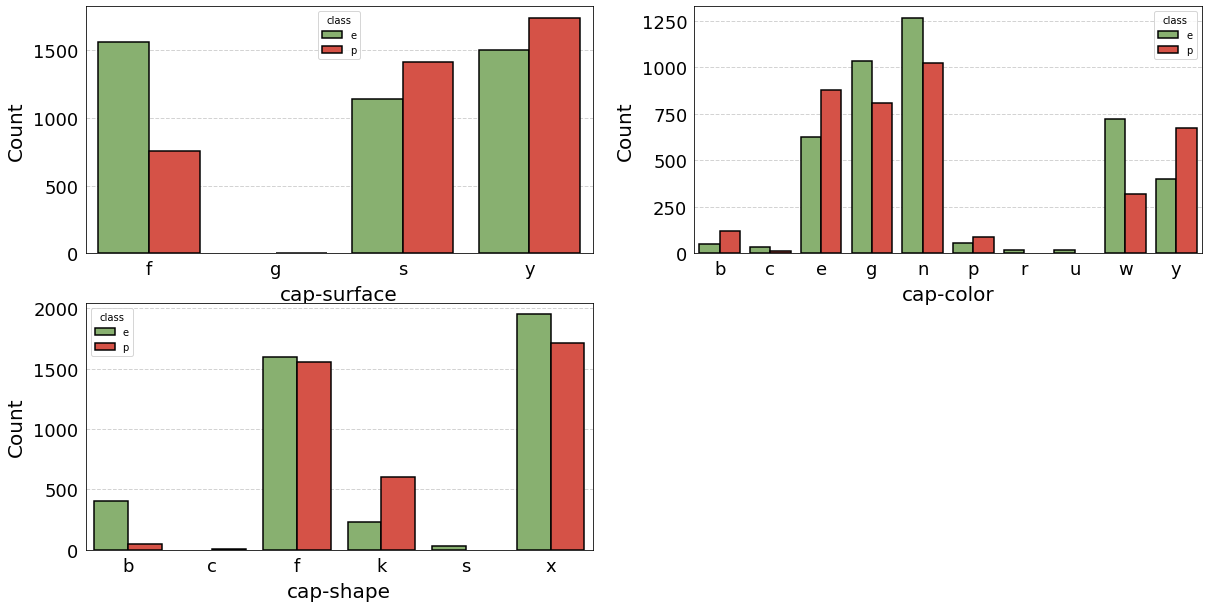

In [20]:
make_barplot(['cap-surface', 'cap-color', 'cap-shape'])

- ***Cap Shape***: 
    - c (conical), the mushroom is poisonous 
    - s (sunken) the mushroom is edible.
    - f (flat) and x (convex) are the most frequent categories and are balanced for both the classes 
- ***Cap Surface***: not a good marker for determining the class
    - g(grooves) the mushroom is poisonous. 
- ***Cap Color***: 
    - r (green) and u (purple), the mushroom is poisonous 

<div style="height:200px;">
       <img style="float:left; display:inline" src="https://mycologyst.art/images/identification/gill-spacing-types.png"        width="25%"/>
       <img style="float:left; display:inline" src="https://mycologyst.art/images/identification/gill-attachments/free-gill-attachment.png"      width="25%"/>
       <img style="float:left; display:inline" src="https://mycologyst.art/images/identification/gill-attachments/adnate-gill-attachment.png" width="25%"/>
</div>

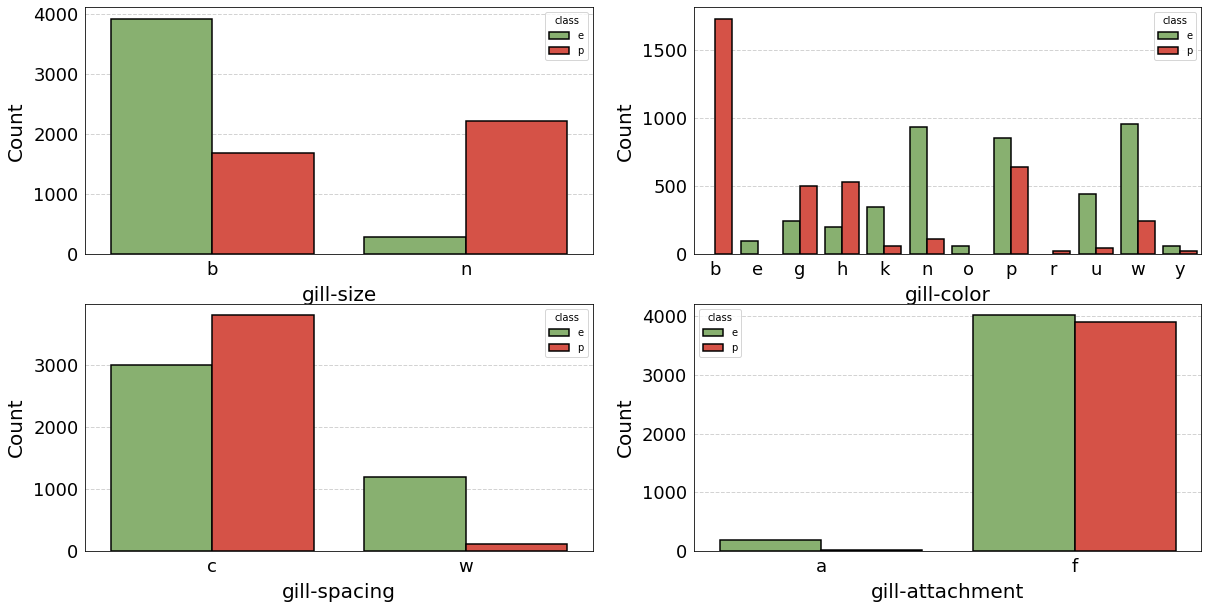

In [21]:
make_barplot(['gill-size', 'gill-color', 'gill-spacing', 'gill-attachment'])

- ***Gill attachment*** and ***gill size*** seem to have distribution in both classes with no predominant class.
- ***Gill color***: a good marker for determing the class
    - b(buff), e(red) and o(orange) implies edible
    - r(green) implies poisonous.
- ***Gill spacing***: not so good for determining the class
    - w(crowded) mostly edible

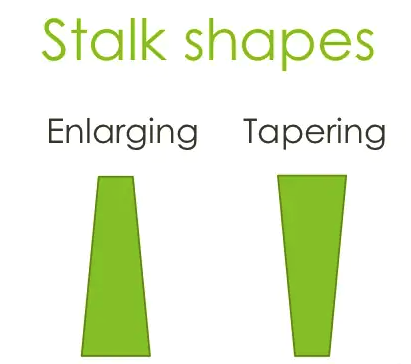

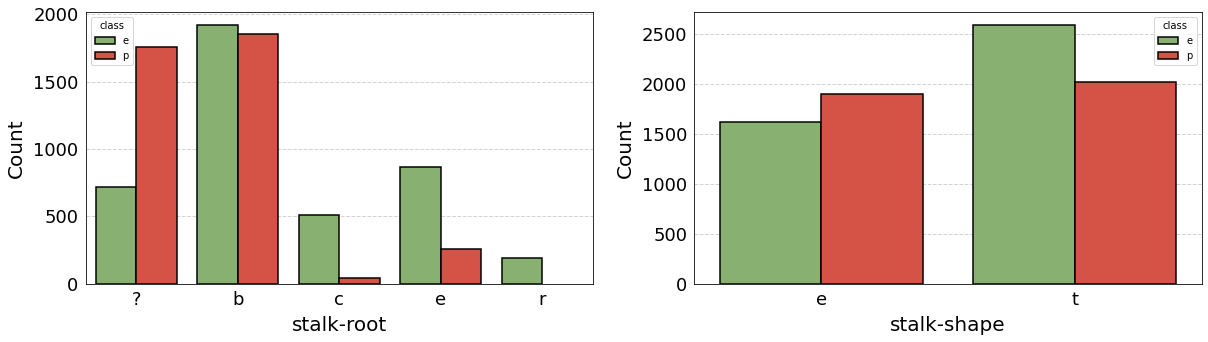

In [22]:
make_barplot(['stalk-root', 'stalk-shape'])

- ***Stalk shape*** does not seem to contribute to decide the class of mushroom. 
- ***Stalk root***:
    - r(rooted) is edible.

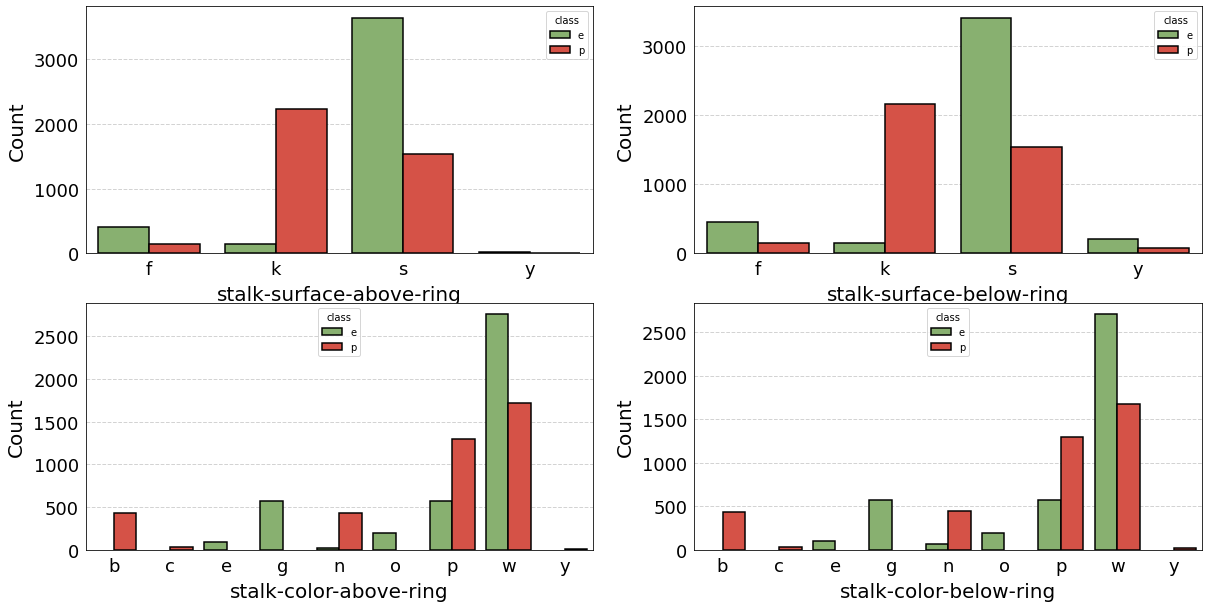

In [23]:
make_barplot(['stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring'])

- ***Stalk surface***, either ***above or below the ring*** have distribution in both the classes and so they are not good marker for determining the class.
- ***Stalk color above and below the ring*** are good markers for determining the class
    - e(red), g(grey) or o(orange) implies an edible mushroom.
    - b(buff), c(cinnamon) or y(yellow) implies that the mushroom is poisonous.

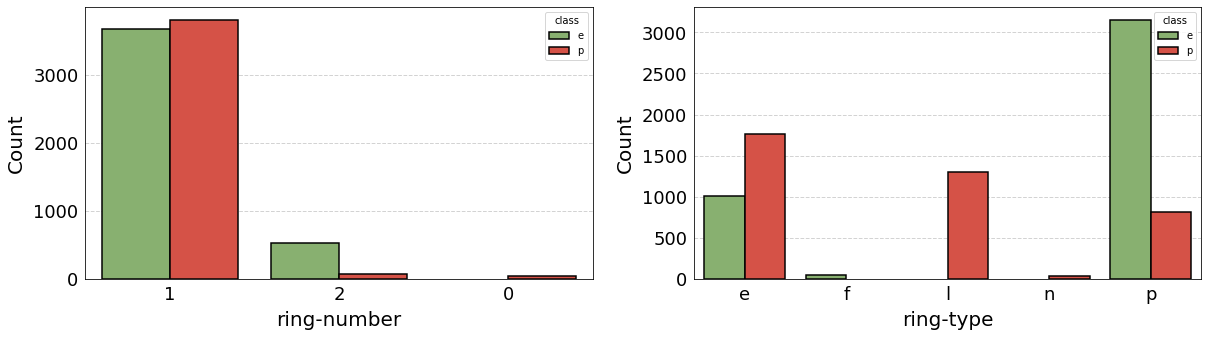

In [24]:
make_barplot(['ring-number', 'ring-type'])

- ***Ring type***: good marker for determing the class
    - l (large) only poisonous 
    - p (pendant)the majority is edible

- ***Ring number***: the majority is 1 but for values 2 and 0 there's a good discrimination

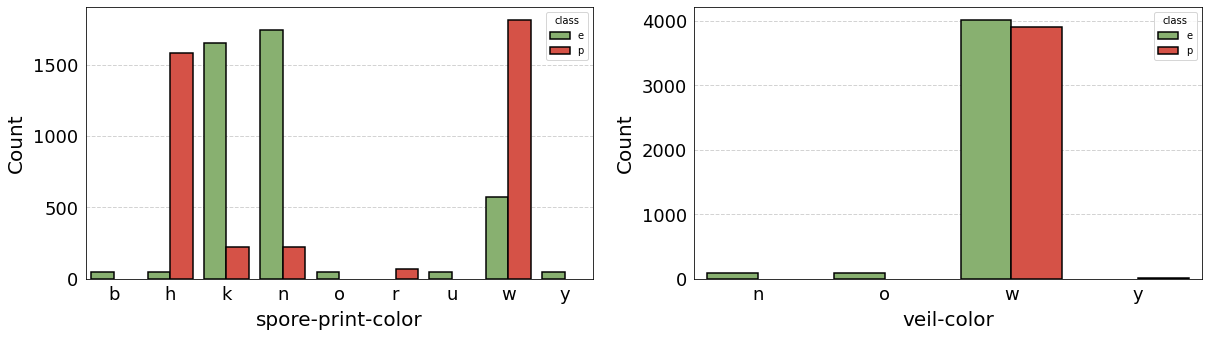

In [25]:
make_barplot(['spore-print-color', 'veil-color'])

**Spore print color** is good markers for determining the class of a mushroom.

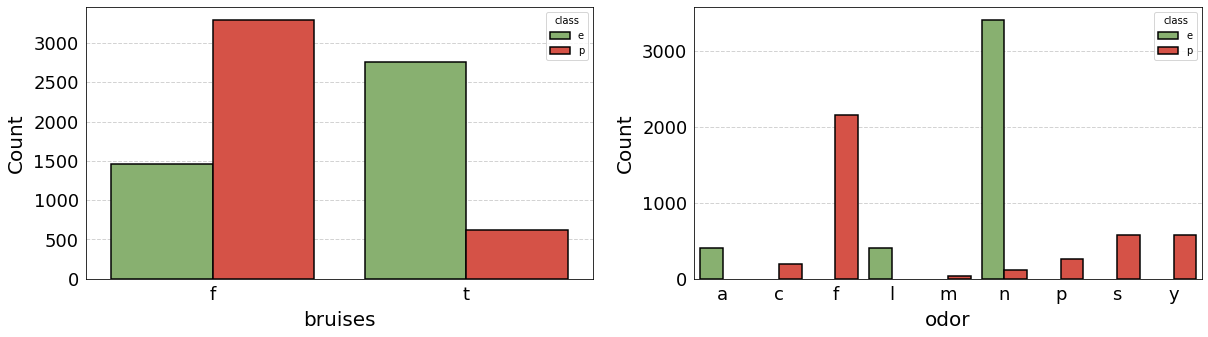

In [26]:
make_barplot(['bruises', 'odor'])

- ***Bruises*** can be a useful marker for determing the class of mushrooms. 
- ***Odor*** is the most effective marker encountered so far. 
    - a(almond), c(creosote), or l(anise), the mushroom is edible
    - m(musty), p(pungent), s(spicy) or y(fishy), the mushroom is poisonous. 

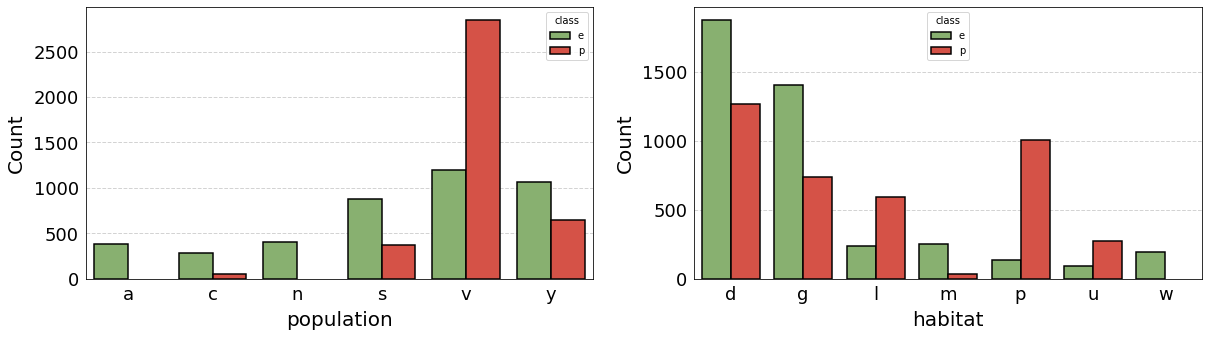

In [27]:
make_barplot(['population', 'habitat']) 

- ***Population***: a (abundant) or n(numerous), the mushroom is edible. It seems to be a good marker for determining the class.
- ***Habitat***: w(waste), then the mushroom is poisonous.

### Correlation

Now we want to analyze the correlation among attributes. Since the attributes are nominal, we decided to use the Cramer's V.

In [28]:
def cramers_V(var1,var2):
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))  # Cross table building.
    stat = chi2_contingency(crosstab)[0]  # Keeping of the test statistic of the Chi2 test.
    obs = np.sum(crosstab)  # Number of observations.
    mini = min(crosstab.shape)-1  # Take the minimum value between the columns and the rows of the cross table.
    return (stat/(obs*mini))

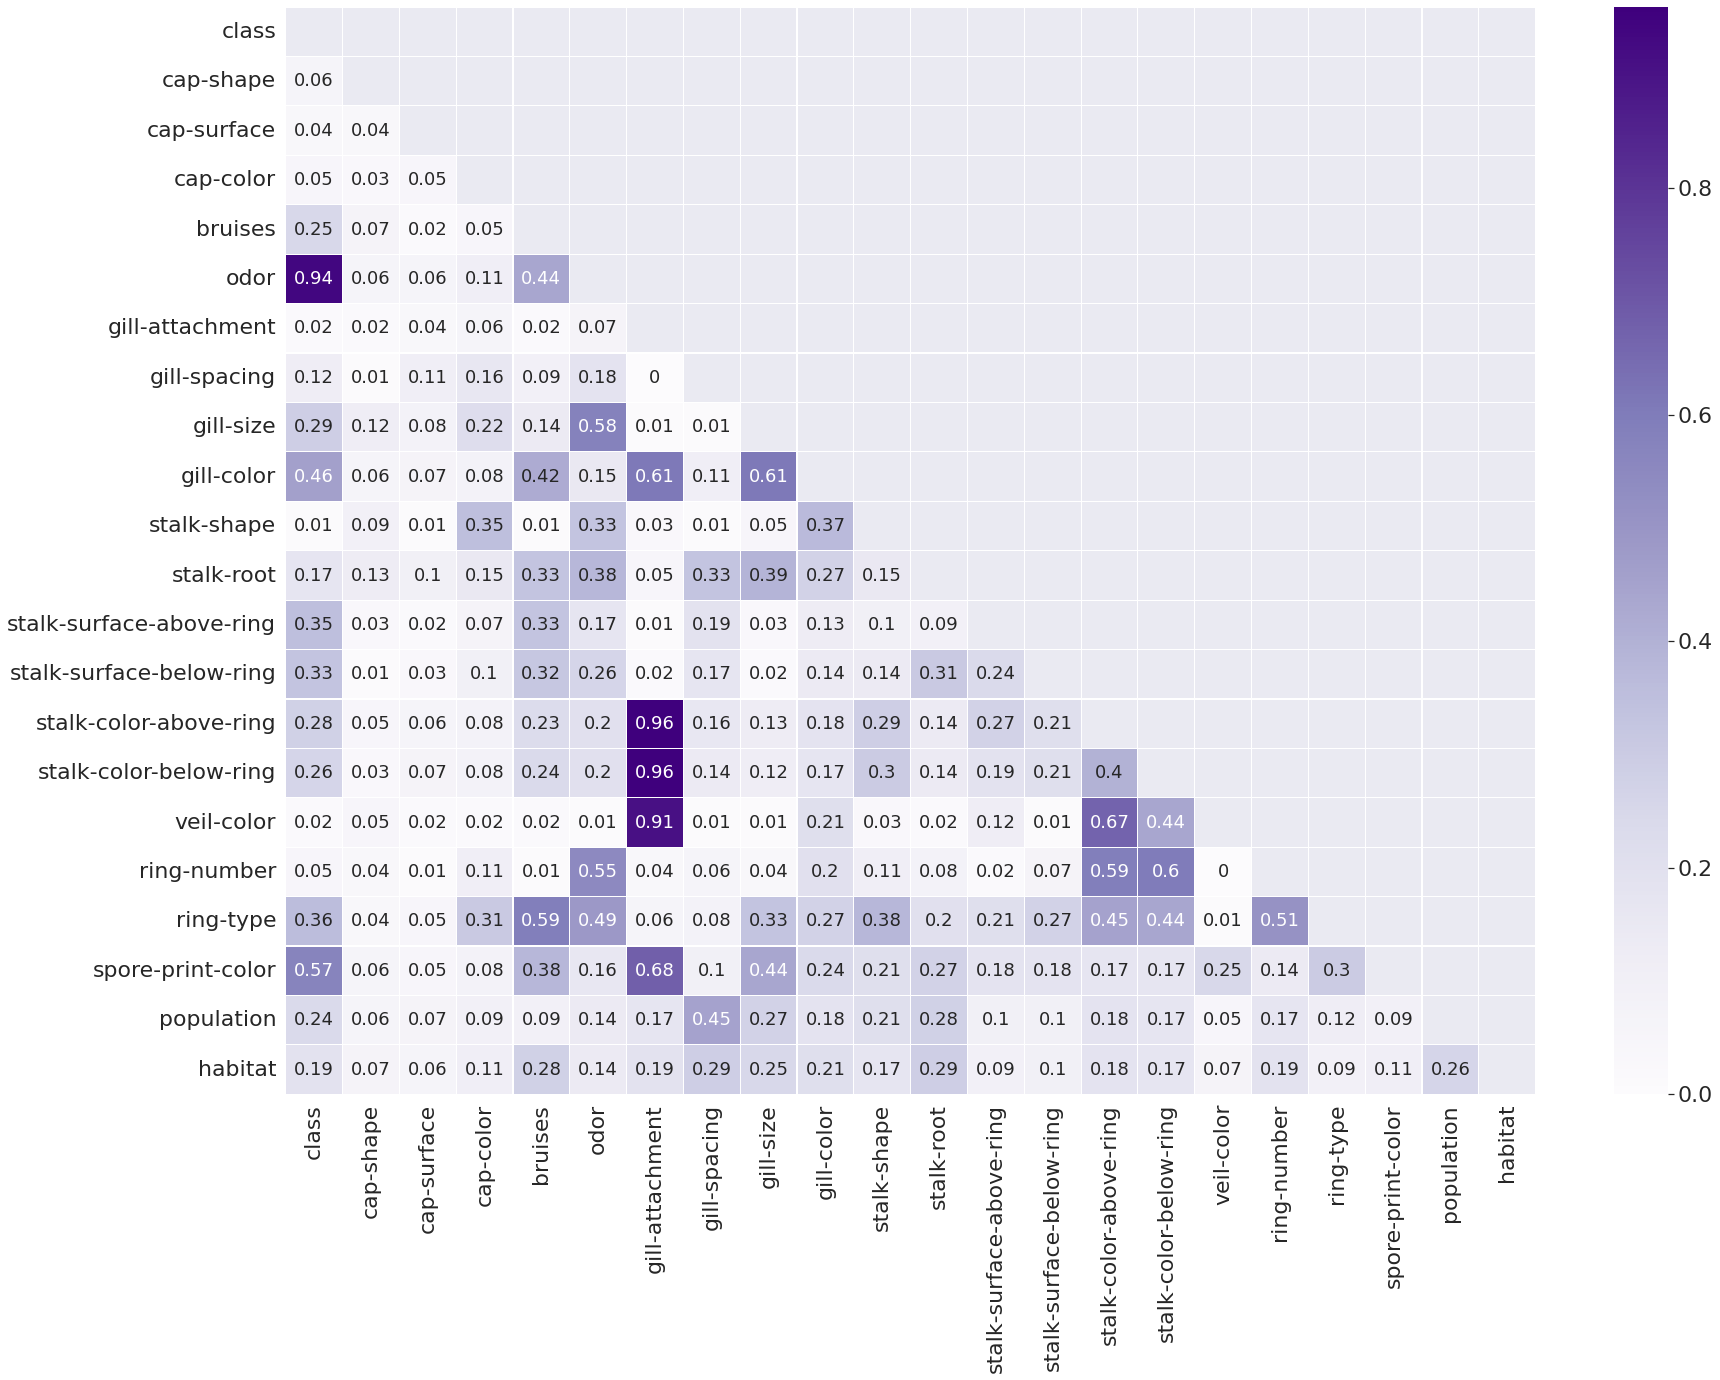

In [29]:
# Make Cramer's V matrix of each attriute
rows = []
sns.set(font_scale=2)
for var1 in df:
    col = []
    for var2 in df:
        cramers =cramers_V(df[var1], df[var2])  # Cramer's V test.
        col.append(round(cramers,2))  # Keeping of the rounded value of the Cramer's V.
    rows.append(col)
  
cramers_results = np.array(rows)
corr = pd.DataFrame(cramers_results, columns=df.columns, index=df.columns)

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(28, 20))
sns.heatmap(corr,linewidths=.1, mask=mask, cmap="Purples", annot=True, annot_kws={"size": 18})
plt.show()

Through the Cramer's V and according from what we found in the plots above, we can conferm that:
- ***Odor*** is the **best marker** for detecting the ediblness of the mushrooms 
- Possible good marker such as the **stalk attributes**, **spore print color**, the **gill-color**, the precence of **bruises** and the **ring type**.

- **Gill-attachmentis** is highly correlated with **veil-color**, **stalk-color above and below ring**.

- ***Bad marker***: **ring-number, veil-color, stalk-shape, cap attributes** but some of them will be taken into account for the process of feature selection. 

### Conditional plot
The aim of this section is to compute and visualize the probability of values, given an attribute, to be edible or poisonous given some conditions and considering the previous results.

In [30]:
# Compute and plotting conditional probability

from copy import copy

plt.style.use('classic')
plt.rcParams.update({'font.size': 20})


# Compute conditional probability
def calculate_cond_prob(df, cond_a, cond_b):
  a = df[cond_a & cond_b]['class'].count()
  b = df[cond_b]['class'].count()
  return a/b


# Build a unique AND condition given a list of terms
def build_condition(conds):
    building_cond = True
    for cond in conds:
      building_cond &= cond
    
    return building_cond


# Set condition for the conditional probability
def get_dict_prob(df, cond_a, cond_b, attr_a=False, attr_b=False):
  prob_dict = dict()

  # Check if cond_a, cond_b are list type
  if (isinstance(cond_a, list) and isinstance(cond_b, list)):

    # concat conditions
    cond_a= build_condition(cond_a)
    cond_b= build_condition(cond_b)

  elif isinstance(cond_a, list):
    cond_a= build_condition(cond_a)
    
  elif isinstance(cond_b, list):
    cond_b = build_condition(cond_b)

  if attr_a:
    for value in df[attr_a].unique():
      cond_a_new = copy(cond_a)
      cond_a_new &= (df[attr_a] == value)
      prob_dict[value] = calculate_cond_prob(df, cond_a_new, cond_b)
  
  elif attr_b:
      for value in df[attr_b].unique():
        cond_b_new = copy(cond_b)
        cond_b_new &= (df[attr_b] == value)
        prob_dict[value] = calculate_cond_prob(df, cond_a, cond_b_new)

  return prob_dict


# plotting the conditional probability
def plot_cond_prob(prob_e, prob_p, x_label='', pos='best'):
  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

  x = np.arange(len(prob_e.keys()))
  width = 0.35

  fig, ax = plt.subplots()
  fig.set_size_inches(7, 5)
  fig.set_facecolor('w')
  
  ax.grid(axis="y", linewidth=1, color="lightgrey", linestyle="--", zorder=0)

  ax.bar(x - width/2, prob_e.values(), width, linewidth=2, label='edible', color=colors[0], zorder=3)
  ax.bar(x + width/2, prob_p.values(), width, linewidth=2, label='poisonous', color=colors[1], zorder=3)

  ax.set_ylabel('Probability')
  ax.set_xlabel(x_label)
  ax.set_xticks(x)
  ax.set_xticklabels(prob_e.keys())
  ax.legend(loc=pos, prop={'size': 17})
  ax.set_ylim(0, 1.05)

  fig.tight_layout()

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


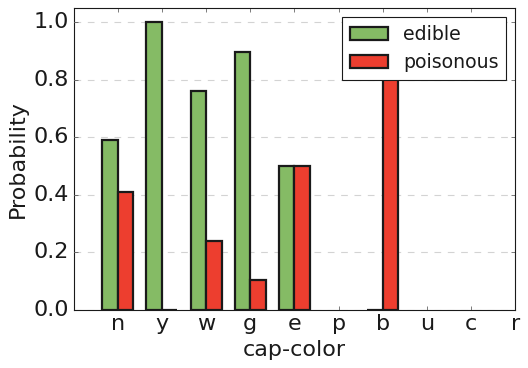

In [31]:
list_cond_b = [(df['cap-shape']== 'f'), (df['stalk-shape']== 't'), (df['veil-color']== 'w')]

prob_e = get_dict_prob(df, df['class']=='e', list_cond_b, attr_b='cap-color') 
prob_p = get_dict_prob(df, df['class']=='p', list_cond_b, attr_b='cap-color')
plot_cond_prob(prob_e, prob_p, x_label='cap-color', pos=1)

In [32]:
def print_info_values(cond, attr):
    for value in df[attr].unique():
        print(value, ': ', len(df[(cond) & (df[attr] == value)]))

In [33]:
print_info_values((df['cap-shape']== 'f') & (df['stalk-shape']== 't') & (df['veil-color']== 'w'), 'cap-color')

n :  704
y :  24
w :  200
g :  464
e :  576
p :  0
b :  48
u :  0
c :  0
r :  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


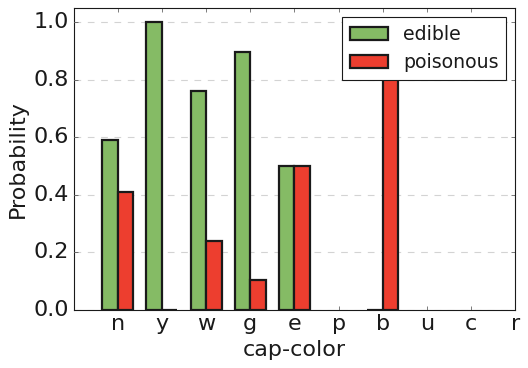

In [34]:
list_cond_b = [(df['cap-shape']== 'x'), (df['stalk-shape']== 't'), (df['veil-color']== 'w')]

prob_e = get_dict_prob(df, df['class']=='e', list_cond_b, attr_b='cap-color') 
prob_p = get_dict_prob(df, df['class']=='p', list_cond_b, attr_b='cap-color')
plot_cond_prob(prob_e, prob_p, x_label='cap-color', pos=1)

In [35]:
print_info_values((df['cap-shape']== 'x') & (df['stalk-shape']== 't') & (df['veil-color']== 'w'), 'cap-color')

n :  704
y :  24
w :  200
g :  464
e :  576
p :  0
b :  48
u :  0
c :  0
r :  0


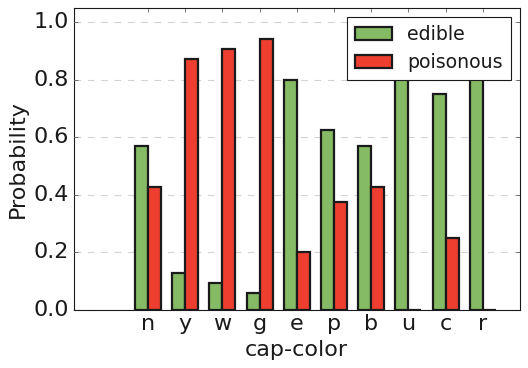

In [36]:
list_cond_b = [(df['cap-shape']== 'f'), (df['stalk-shape']== 'e'), (df['veil-color']== 'w')]

prob_e = get_dict_prob(df, df['class']=='e', list_cond_b, attr_b='cap-color') 
prob_p = get_dict_prob(df, df['class']=='p', list_cond_b, attr_b='cap-color')
plot_cond_prob(prob_e, prob_p, x_label='cap-color', pos=1)

In [37]:
print_info_values((df['cap-shape']== 'f') & (df['stalk-shape']== 'e') & (df['veil-color']== 'w'), 'cap-color')

n :  168
y :  376
w :  86
g :  344
e :  20
p :  32
b :  28
u :  8
c :  16
r :  8


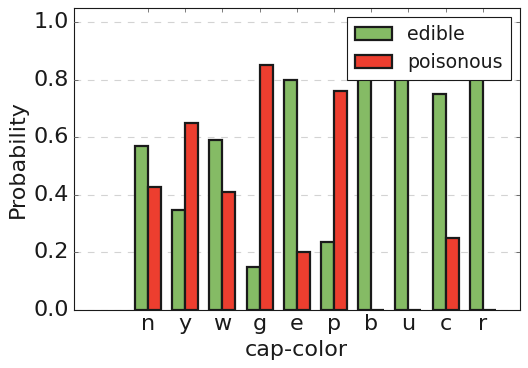

In [38]:
list_cond_b = [(df['cap-shape']== 'x'), (df['stalk-shape']== 'e'), (df['veil-color']== 'w')]

prob_e = get_dict_prob(df, df['class']=='e', list_cond_b, attr_b='cap-color') 
prob_p = get_dict_prob(df, df['class']=='p', list_cond_b, attr_b='cap-color')
plot_cond_prob(prob_e, prob_p, x_label='cap-color', pos=1)

In [39]:
print_info_values((df['cap-shape']== 'x') & (df['stalk-shape']== 'e') & (df['veil-color']== 'w'), 'cap-color')

n :  168
y :  504
w :  312
g :  456
e :  20
p :  84
b :  16
u :  8
c :  16
r :  8


Since we observed that the **cap-shape**, **stalk-shape** and **veil-color** are individually bad features, we asked if together they could create a good one. As we can observe from these plots and from the frequencies, the **cap shape** isn't as good as **cap color** and **stalk shape** together, in fact despite we change the value of the cap shape from 'x' to 'f' (which are the most common values for both the classes), the probabilities and the frequencies don't change so much, but when we change the stalk-shape we can observe a significant change in probabilities and frequencies.

NOTE: It could be interesting to put together in one unique feature the concatenation of the color of the cap and the shape of the stalk.

### Feature reshaping
In order to perform the following tasks, we had to prepare out data.

We decide to manually apply a mapping on binary features for better explainability:

In [40]:
df['class'] = df['class'].map({'p': 0, 'e': 1}).astype(str)
df['bruises'] = df['bruises'].map({'t': 1, 'f': 0}).astype(str)
df['gill-attachment'] = df['gill-attachment'].map( {'a': 1, 'f': 0}).astype(str)
df['gill-spacing'] = df['gill-spacing'].map({'c': 0, 'w': 1}).astype(str)
df['gill-size'] = df['gill-size'].map({'b': 1, 'n': 0}).astype(str)
df['stalk-shape'] = df['stalk-shape'].map({'e': 1, 't': 0}).astype(str)

df.rename(columns={"class": "edible"}, inplace=True)

df.head()

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,1,p,0,0,0,k,1,e,s,s,w,w,w,1,p,k,s,u
1,1,x,s,y,1,a,0,0,1,k,1,c,s,s,w,w,w,1,p,n,n,g
2,1,b,s,w,1,l,0,0,1,n,1,c,s,s,w,w,w,1,p,n,n,m
3,0,x,y,w,1,p,0,0,0,n,1,e,s,s,w,w,w,1,p,k,s,u
4,1,x,s,g,0,n,0,1,1,k,0,e,s,s,w,w,w,1,e,n,a,g


We decide to use one hot encoding because it allows the representation of categorical data to be more expressive. In fact, as binary columns for each value of each attributes, we can better highlight the presence or not of every single characteristic. 

Many algorithms cannot work directly with categorical data, the categories must be converted into integers. This is required for both input and output variables that are categorical; we cannot directly convert into integers because there may be problems when there is no ordinal relationship, like our case, and this may can negative affects some processes.

So we performed one hot encoding for ordinal, non-binary features.

In [41]:
# One hot encoding for non-binary features.
# Optional: remove some columns
def reshaping(df, remove_cols= None):
    temp = df.copy()
    if remove_cols != None:
        temp.drop(remove_cols, axis=1, inplace = True)
        
    ohe_cols= [col for col in temp.columns if (len(temp[col].unique()) > 2)]

    return pd.get_dummies(temp, columns=ohe_cols)

In [42]:
# Change the name columns of dataframe for rules analysis
def transform_columns(df):
    for col in df.columns.tolist():
        df[col] = df[col].astype(str) + '_' + col
    return df

## Finding general rules
The objective of this section is to find some common rules among the attributes of the mushrooms.

In [43]:
# prepare dataset to be processed
df_ohe1= reshaping(df)
df_ohe1.head()

,edible,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,...,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_0,ring-number_1,ring-number_2,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


### Feature selection
Before applying the algorithm for discovering rules, we decide to apply a feature selection process to reduce the complexity and to discard attrubutes that are not useful using SelectKBest with chi-square.

In [44]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Remove target value
y = df_ohe1[['edible']]
df_ohe1.drop(['edible'], axis=1, inplace=True)

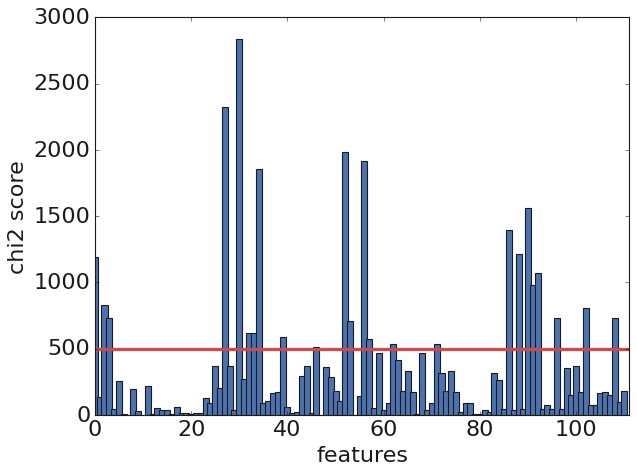

n_features:  24


In [45]:
# feature selection using chi2
fs= SelectKBest(score_func=chi2, k='all')
fs.fit(df_ohe1,y)
X_fs= fs.transform(df_ohe1.copy())

threshold = 500
def print_scores(scores, threshold):
  # plots the chi2 value for every feature
  fig, ax = plt.subplots()
  fig.set_facecolor('w')
  fig.tight_layout()
  plt.xlim(0, len(scores))
  width= 1.25
  ax.bar(range(len(scores)), scores, width= width)
  plt.axhline(y=threshold, color='r', linestyle='-', linewidth=3)
  plt.ylabel('chi2 score')
  plt.xlabel('features')
  plt.show()


print_scores(fs.scores_, threshold)
count= 0
for score in fs.scores_:
  if score >= threshold:
    count += 1
print('n_features: ', count)

In [46]:
selector = SelectKBest(chi2, k=24).fit(df_ohe1, y)
df_selected = selector.transform(df_ohe1)

mask = selector.get_support()
new_features = []  # The list of the K best features

for bool, feature in zip(mask, list(df_ohe1.columns)):
    if bool:
        new_features.append(feature)

df_selected = pd.DataFrame(df_selected, columns=new_features)

In [47]:
df_selected.head()

,bruises,gill-spacing,gill-size,odor_f,odor_n,odor_s,odor_y,gill-color_b,gill-color_n,stalk-root_?,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-color-above-ring_g,stalk-color-below-ring_g,ring-type_l,ring-type_p,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_w,population_v,habitat_p
0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0
4,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


These are the 21 most important features. Most of these features were already identified during the explorative analysis but now we can see better which are the most important values for each of them.

In [48]:
def pattern_mining(df, params):
    rules_list= list()
    values = df.values.tolist()
    rules = apriori(values, supp=params['sup'], zmin=params['zmin'], zmax=params['zmax'], target=params['target'], conf=params['conf'], report=params['report']) 
    #print('Number of rules:', len(rules))
    for r in rules:
        if params['filter'] is None:
            rules_list.append(r)
        elif r[0] == params['filter']:
            rules_list.append(r)

    return rules_list

In [49]:
df_selected['edible'] = df['edible']
df_selected = transform_columns(df_selected)

In [50]:
params = {'sup': 35,
          'zmin': 1,
          'zmax': 3,
          'target': 'r',  # association rules
          'conf': 100,
          'report': 'sc', # support s, confidence c
          'filter': None} 

rules = pattern_mining(df_selected, params)

# We are looking for positive rules, because they are more informative.
for rule in rules:
    if (('1' in rule[0]) or ('1' in rule[1])):
        print(rule)

('1_ring-type_p', ('1_bruises', '0_stalk-root_?'), 0.39192516001969474, 1.0)
('1_ring-type_p', ('1_bruises', '0_spore-print-color_w'), 0.3870014771048744, 1.0)
('1_stalk-surface-above-ring_s', ('1_bruises', '0_odor_f'), 0.38010832102412606, 1.0)
('1_stalk-surface-above-ring_s', ('1_bruises', '0_spore-print-color_h'), 0.38010832102412606, 1.0)


These are most significative rules found.

## Exploring rules on edibility 

### Assumptions

We decided to remove:
- **odor**, because we want to discriminate the class just by seeing the mushroom;
- the **type of the root of the stalk, the color or the spores, the population and the habitat**, because in some photos these attributes may be hard or impossible to see.

In [51]:
removed_cols= ['odor', 'stalk-root', 'spore-print-color', 'population', 'habitat']
# prepare dataset
df1 = reshaping(df, remove_cols= removed_cols)
df1.head()

,edible,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_0,ring-number_1,ring-number_2,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p
0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
2,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
4,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0


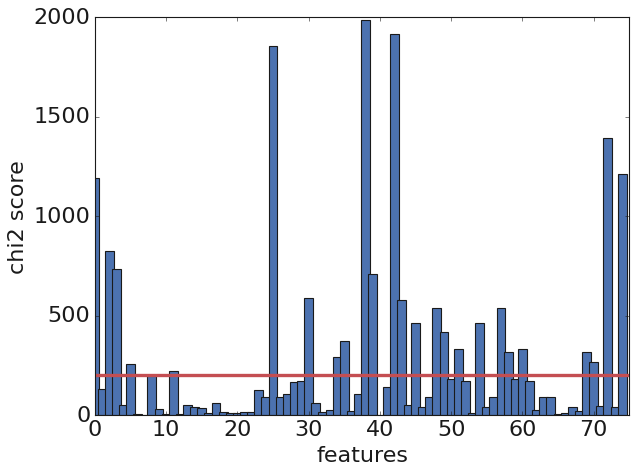

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X= df1.iloc[:, 1:].values
Y= df1.iloc[:, 0:1].values

# feature selection using chi2
fs= SelectKBest(score_func=chi2, k='all')
fs.fit(X,Y)
X_fs= fs.transform(X)

threshold = 200
print_scores(fs.scores_, threshold)

This plot shows the feature importance score for each feature. As we can see, there are some features with very high score and others with very low score. So we decide to put a threshold in order to select the K-best according to the score.

In [53]:
# Counting the number of features with an importance above the threshold.

count= 0
for i in range(len(fs.scores_)):
  if (fs.scores_[i] >= threshold):
    #print('Feature %d: %f' % (i, fs.scores_[i]))
    count += 1
  
print('n_features: ', count)

n_features:  25


25 features selected

In [54]:
fs= SelectKBest(score_func=chi2, k= count)
fs.fit(X,Y)
X_fs= fs.transform(X)

In [55]:
dict_idx_cols= dict()
important_features= list()

for col in df1.columns:
  dict_idx_cols[df1.columns.get_loc(col)] = col

dict_idx_cols= {k-1:v for (k,v) in dict_idx_cols.items() }

for f_selected in fs.get_support(indices=True).tolist():
  important_features.append(dict_idx_cols[f_selected])

for feature,score in zip(important_features, fs.get_support(indices=True).tolist()):
  print(feature, ': ', fs.scores_[score] )

bruises :  1194.2773520082696
gill-spacing :  826.7952744441203
gill-size :  732.5652822318123
cap-shape_b :  255.71233340852407
cap-surface_f :  221.636970453203
gill-color_b :  1856.849846782431
gill-color_n :  590.7610883616463
gill-color_u :  291.27685049206866
gill-color_w :  370.37680174809344
stalk-surface-above-ring_k :  1986.4084940843877
stalk-surface-above-ring_s :  711.6166120484622
stalk-surface-below-ring_k :  1914.3713894833327
stalk-surface-below-ring_s :  577.0364040572767
stalk-color-above-ring_b :  464.2124616956078
stalk-color-above-ring_g :  536.0304182509506
stalk-color-above-ring_n :  417.3080785579184
stalk-color-above-ring_p :  331.52754913732406
stalk-color-below-ring_b :  464.2124616956078
stalk-color-below-ring_g :  536.0304182509506
stalk-color-below-ring_n :  316.67469327357395
stalk-color-below-ring_p :  331.52754913732406
ring-number_2 :  314.96211995634565
ring-type_e :  266.63310021289607
ring-type_l :  1392.6373850868235
ring-type_p :  1213.9952194289

As we expected from the analysis above, the attributes of the stalk, in particular, the fact that the surface is or isn't of type k, is the most important attribute. Moreover, the presence of bruises, the ring type and the fact that a mushrooms has buff color of the gills, are the most important features since they have the highest chi2 scores. This conferms our analysis we've done on the conditional plots and on the Cramer's V matrix

In [56]:
df_transformed= pd.DataFrame(X_fs, columns=important_features)
df_transformed['edible']= Y
df_transformed.head()

,bruises,gill-spacing,gill-size,cap-shape_b,cap-surface_f,gill-color_b,gill-color_n,gill-color_u,gill-color_w,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-color-above-ring_b,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_p,stalk-color-below-ring_b,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_p,ring-number_2,ring-type_e,ring-type_l,ring-type_p,edible
0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1


We need to transform our dataset in order to better understand the content of the rules

In [57]:
# transform dataset
df_transformed = transform_columns(df_transformed)
df_transformed.head()

,bruises,gill-spacing,gill-size,cap-shape_b,cap-surface_f,gill-color_b,gill-color_n,gill-color_u,gill-color_w,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-color-above-ring_b,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_p,stalk-color-below-ring_b,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_p,ring-number_2,ring-type_e,ring-type_l,ring-type_p,edible
0,1_bruises,0_gill-spacing,0_gill-size,0_cap-shape_b,0_cap-surface_f,0_gill-color_b,0_gill-color_n,0_gill-color_u,0_gill-color_w,0_stalk-surface-above-ring_k,1_stalk-surface-above-ring_s,0_stalk-surface-below-ring_k,1_stalk-surface-below-ring_s,0_stalk-color-above-ring_b,0_stalk-color-above-ring_g,0_stalk-color-above-ring_n,0_stalk-color-above-ring_p,0_stalk-color-below-ring_b,0_stalk-color-below-ring_g,0_stalk-color-below-ring_n,0_stalk-color-below-ring_p,0_ring-number_2,0_ring-type_e,0_ring-type_l,1_ring-type_p,0_edible
1,1_bruises,0_gill-spacing,1_gill-size,0_cap-shape_b,0_cap-surface_f,0_gill-color_b,0_gill-color_n,0_gill-color_u,0_gill-color_w,0_stalk-surface-above-ring_k,1_stalk-surface-above-ring_s,0_stalk-surface-below-ring_k,1_stalk-surface-below-ring_s,0_stalk-color-above-ring_b,0_stalk-color-above-ring_g,0_stalk-color-above-ring_n,0_stalk-color-above-ring_p,0_stalk-color-below-ring_b,0_stalk-color-below-ring_g,0_stalk-color-below-ring_n,0_stalk-color-below-ring_p,0_ring-number_2,0_ring-type_e,0_ring-type_l,1_ring-type_p,1_edible
2,1_bruises,0_gill-spacing,1_gill-size,1_cap-shape_b,0_cap-surface_f,0_gill-color_b,1_gill-color_n,0_gill-color_u,0_gill-color_w,0_stalk-surface-above-ring_k,1_stalk-surface-above-ring_s,0_stalk-surface-below-ring_k,1_stalk-surface-below-ring_s,0_stalk-color-above-ring_b,0_stalk-color-above-ring_g,0_stalk-color-above-ring_n,0_stalk-color-above-ring_p,0_stalk-color-below-ring_b,0_stalk-color-below-ring_g,0_stalk-color-below-ring_n,0_stalk-color-below-ring_p,0_ring-number_2,0_ring-type_e,0_ring-type_l,1_ring-type_p,1_edible
3,1_bruises,0_gill-spacing,0_gill-size,0_cap-shape_b,0_cap-surface_f,0_gill-color_b,1_gill-color_n,0_gill-color_u,0_gill-color_w,0_stalk-surface-above-ring_k,1_stalk-surface-above-ring_s,0_stalk-surface-below-ring_k,1_stalk-surface-below-ring_s,0_stalk-color-above-ring_b,0_stalk-color-above-ring_g,0_stalk-color-above-ring_n,0_stalk-color-above-ring_p,0_stalk-color-below-ring_b,0_stalk-color-below-ring_g,0_stalk-color-below-ring_n,0_stalk-color-below-ring_p,0_ring-number_2,0_ring-type_e,0_ring-type_l,1_ring-type_p,0_edible
4,0_bruises,1_gill-spacing,1_gill-size,0_cap-shape_b,0_cap-surface_f,0_gill-color_b,0_gill-color_n,0_gill-color_u,0_gill-color_w,0_stalk-surface-above-ring_k,1_stalk-surface-above-ring_s,0_stalk-surface-below-ring_k,1_stalk-surface-below-ring_s,0_stalk-color-above-ring_b,0_stalk-color-above-ring_g,0_stalk-color-above-ring_n,0_stalk-color-above-ring_p,0_stalk-color-below-ring_b,0_stalk-color-below-ring_g,0_stalk-color-below-ring_n,0_stalk-color-below-ring_p,0_ring-number_2,1_ring-type_e,0_ring-type_l,0_ring-type_p,1_edible


### Rules for edibilness

In [58]:
colors[0], colors[1] = colors[1], colors[0]

def get_conds(r):
  conds= list()
  for cond in r[1]:
    val = cond
    attr= cond.split('_')
    try:
        attr= attr[1] + '_' + attr[2]
    except IndexError:
        attr= attr[1]
    conds.append( (attr, val) )
  
  return conds


def build_conds(df, conds):
  full_condition= True
  for cond in conds:
    full_condition &= ( df[cond[0]] == cond[1] )
  return full_condition


def plot_freq(ax, i, df, cond, class_='', rule= None):
  # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

  x = np.arange(len(df['edible'].unique()))
  freqs= list()
  width = 0.35

  ax[i].grid(axis="y", linewidth=1, color="lightgrey", linestyle="--", zorder=1)
  for val in df[class_].unique():
    freqs.append( df[cond & (df[class_]== val)][class_].count() )

  ax[i].bar(df[class_].unique(), freqs, color=colors, zorder=3)

  #ax[i].set_ylabel("Count", fontsize=20, labelpad=7)
  #ax[i].set_xlabel(feature, fontsize=10, labelpad=7)
  ax[i].set_ylabel('frequencies')
  
  #if rule != None:
  #  ax[i].axes.set_title(str(rule),fontsize=15)

In [59]:
def print_stats(df,rules, title):
    print('number of rules for ' +title+ ' mushrooms:', len(rules))
    for idx, rule in enumerate(rules):
        print(idx, rule)

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(14, 5)
    fig.set_facecolor('w')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.7)

    ax = ax.ravel()

    for idx, rule in enumerate(rules):
        plot_freq(ax, idx, df, build_conds(df, get_conds(rule)), 'edible', rule[1])
    
    for i in range(3 - len(rules)):
        fig.delaxes(ax[2-i])

    plt.show()

In [60]:
def delete_satisfied_instance(df, rule):

    # do un indice al df originale trasformato
    df['idx'] = [x for x in range(0, df.shape[0])]

    df2= df[build_conds( df, get_conds(rule))]
    df = pd.concat([df,df2]).drop_duplicates(keep=False)

    df.drop(columns= ['idx'], inplace = True)
    print(df['edible'].value_counts())
    return df

number of rules for poisonous mushrooms: 3
0 ('0_edible', ('1_stalk-surface-above-ring_k', '0_ring-type_p'), 0.2742491383554899, 1.0)
1 ('0_edible', ('1_stalk-surface-above-ring_k', '0_gill-spacing'), 0.2742491383554899, 1.0)
2 ('0_edible', ('1_stalk-surface-above-ring_k', '0_ring-number_2'), 0.2742491383554899, 1.0)


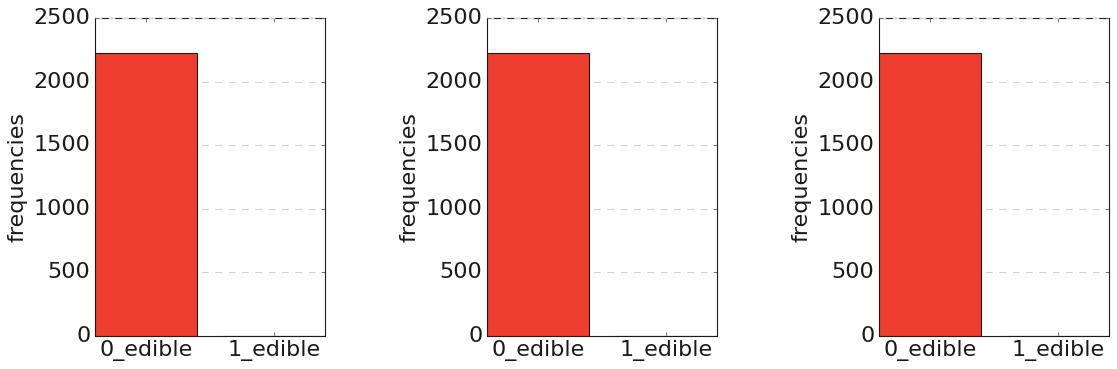

In [61]:
# rules for the poisonous mushrooms
params = {'sup': 27,
          'zmin': 1,
          'zmax': 3,
          'target': 'r',  # association rules
          'conf': 100,
          'report': 'sc', # support s, confidence c
          'filter': '0_edible'}

poison_rules= pattern_mining(df_transformed, params)
print_stats(df_transformed, poison_rules, 'poisonous')

In [62]:
df_transformed= delete_satisfied_instance(df_transformed, poison_rules[2])

1_edible    4208
0_edible    1688
Name: edible, dtype: int64


Since these first rules have the same frequencies, we chose in an arbitraily way one of them. So, since the first rule allows us to identify in a safe way which are the poisonous mushrooms, we can take off them because they are already classified, and we can proceed to identify other rules on the remainings.

number of rules for edible mushrooms: 3
0 ('1_edible', ('1_gill-spacing', '1_gill-size'), 0.1791044776119403, 1.0)
1 ('1_edible', ('1_cap-surface_f', '1_gill-size'), 0.23609226594301222, 1.0)
2 ('1_edible', ('0_bruises', '1_gill-size'), 0.21438263229308005, 1.0)


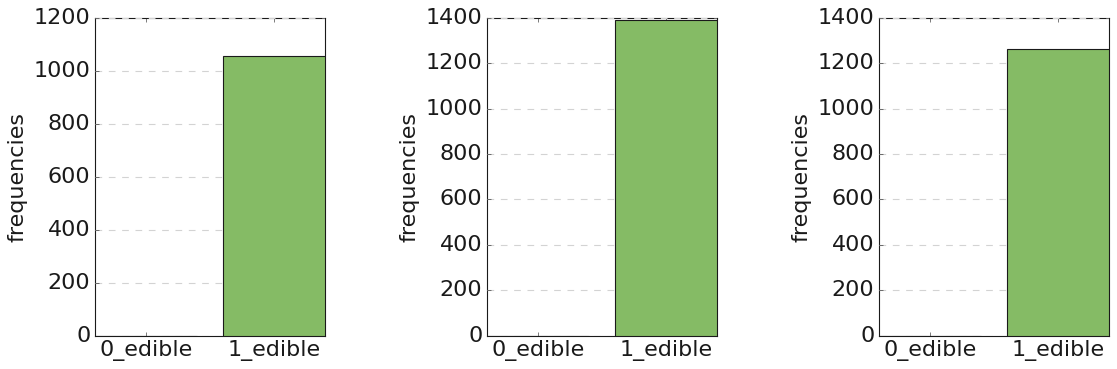

In [63]:
params = {'sup': 17,
          'zmin': 2,
          'zmax': 3,
          'target': 'r',  # association rules
          'conf': 100,
          'report': 'sc', # support s, confidence c
          'filter': '1_edible'} # [value_feature name]  A ==> B ['e_class']

edible_rules = pattern_mining(df_transformed, params)
print_stats(df_transformed, edible_rules, 'edible')

In [64]:
df_transformed= delete_satisfied_instance(df_transformed, edible_rules[1])

1_edible    2816
0_edible    1688
Name: edible, dtype: int64


The second rule allows us to identify a very good number of edible mushrooms. Therefore we proceed by deleting the mushrooms that satisfy this rule.

In [67]:
params = {'sup': 17,
          'zmin': 1,
          'zmax': 2,
          'target': 'r',  # association rules
          'conf': 100,
          'report': 'sc', # support s, confidence c
          'filter': '0_edible'} # [value_feature name]  A ==> B ['e_class']

poison_rules = pattern_mining(df_transformed, params)
print_stats(df_transformed, poison_rules, 'poisonous')

number of rules for poisonous mushrooms: 0


<Figure size 1120x400 with 0 Axes>

In [66]:
df_transformed= delete_satisfied_instance(df_transformed, poison_rules[0])

1_edible    2816
0_edible     824
Name: edible, dtype: int64


This last rule allows us to identify other poisonous mushrooms.

# Conclusions

### Predictive task

Since we assure that in this dataset we can discover some good rules about the poisonousness of the mushrooms we would like to proceed to:

- Create a model to predict whether a mushroom is safe to eat or is poisonous. In particular we want to be very accurate in the poisonous class, since a misclassification of a poisonous mushroom could be fatal;

- Discover if it's possible to get a good set of simple rules in an ELI5 way in order to classify a mushroom, even without a mathematical model.